In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import scipy.stats
import pickle
import os.path

import theano
import theano.tensor as T
# from theano.compile.nanguardmode import NanGuardMode
# from lasagne.updates import adam

In [2]:
### utilities

def sample_categorical(pi):
    pi_cumsum = pi.cumsum(axis = 1)
    return np.apply_along_axis( \
        lambda a: a.searchsorted(np.random.uniform(0, 1)), \
        arr = pi_cumsum, \
        axis = 1, \
    )

def T_logsumexp(x, axis = None, keepdims = False):
    xm = x.max(axis = axis, keepdims = True)
    return T.log(T.exp(x - xm).sum(axis = axis, keepdims = keepdims)) + xm


def init_T_weight(n_in, n_out, name, is_sigmoid = False, is_zero = False):
    if is_zero:
        value = np.zeros((n_in, n_out), dtype = theano.config.floatX)
    else:
        value = np.asarray(
            np.random.uniform(
                low = -np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)
            ),
            dtype = theano.config.floatX
        )
    if is_sigmoid:
        value *= 4
    w = theano.shared(value = value, name = name + '_w', borrow = True)
    b = theano.shared(
        value = np.zeros((n_out,), dtype = theano.config.floatX),
        name = name + '_b',
        borrow = True,
    )
    return w, b

In [14]:
# 2d gmm w/ fixed isotropic variance and fixed cluster distn cluster means have same prior.
# infer Pr[cluster means | samples]

### HYPER PARAMETERS ###

C = 6

# mu[i] ~ Gaussian(mu_mu[i], mu_Sigma[i])
mu_mu = np.zeros((2,))
mu_sigma2 = 2
mu_Sigma = np.eye(2) * mu_sigma2
mu_Lambda = np.eye(2) / mu_sigma2
mu_rvs = [
    sp.stats.multivariate_normal(mu_mu, mu_Sigma) for _ in range(C)
]

# sigma2 fixed, intended to be small
sigma2 = 0.5
Sigma = np.eye(2) * sigma2
Lambda = np.eye(2) / sigma2

# pi categorical over clusters, fixed
pi_prob = 1 / C
pis = np.arange(C)
# pi_rv = sp.stats.bernoulli(pi_eq_1_prob)

# sample number n, fixed for NN
n = 60

### SAMPLE ###

def xs_1d_pca(xs):
#     return (xs ** 2).sum(axis = 2), None, None
    offsets_3d = xs.mean(axis = 1, keepdims = True)  # (k, 1, 2)
    zero_mean_xs = xs - offsets_3d
    Ts = []
    Ws = []
    for i in range(xs.shape[0]):
        U, s, V = np.linalg.svd(zero_mean_xs[i], full_matrices = False)
        T, W = U[:, 0] * s[0], V[0]
        if W[0] <= 0:
            T, W = -T, -W
        Ws.append(W)
        Ts.append(T)
    return np.stack(Ts), np.stack(Ws), offsets_3d

def sort_mus_pca(mus, zs, Ws, offsets_3d, get_argsort = False):
    size = mus.shape[0]
    mus_1d = np.einsum('ijk,ik->ij', mus - offsets_3d, Ws) # transform mus to 1d
#     mus_1d = (mus ** 2).sum(axis = 2)
    mus_1d_argsort = mus_1d.argsort()
    mus = mus[np.arange(size).reshape((size, 1)), mus_1d_argsort]
    zs = mus_1d_argsort.argsort()[np.arange(size).reshape((size, 1)), zs]
    if not get_argsort:
        return mus, zs
    else:
        return mus, zs, mus_1d_argsort

def sort_xs_pca(zs, xs, Ts):
    size = xs.shape[0]
    Ts_argsort = Ts.argsort() # xs order by first principle component
    xs = xs[np.arange(size).reshape((size, 1)), Ts_argsort]
    zs = zs[np.arange(size).reshape((size, 1)), Ts_argsort]
    return zs, xs

# Essentially (observation, hidden) pair
def sample(size = 1, sort_pca = False):
    mus = np.atleast_2d(np.hstack(tuple(rv.rvs(size = size).reshape((size, 1, 2)) for rv in mu_rvs)))
    zs = np.random.choice(pis, size = (size, n))
    xs = np.random.multivariate_normal(np.zeros(2), np.eye(2), size = (size, n)) \
        * np.sqrt(sigma2) + mus[np.arange(size).reshape((size, 1)), zs]
    if sort_pca:
        Ts, Ws, offsets_3d = xs_1d_pca(xs)
        mus, zs = sort_mus_pca(mus, zs, Ws, offsets_3d)
        zs, xs = sort_xs_pca(zs, xs, Ts)
        return mus, zs, xs, Ws, offsets_3d.squeeze(axis = 1)
    return mus, zs, xs


# ignore constant terms.
def get_log_likelihood(mus, zs, xs):
    k = xs.shape[0]
    l = sum(mu_rvs[i].logpdf(mus[:, i]) for i in range(mus.shape[1]))
    l -= ((xs - mus[np.arange(k).reshape((k, 1)), zs]) ** 2).sum(axis = (1, 2)) / (2 * sigma2)
    return l.reshape((k, 1))
#     # assume Bernoulli(0.5) on zs, so ignore

In [4]:
### Gibbs ###

# xs are fixed observations
# mus (C, 2)
# zs  (n,)
# xs  (n, 2)
def gibbs_step(mus, zs, xs):
    # mus
    new_mus = []
    for c in range(C):
        x_cs = xs[0, zs == c]
        t = np.linalg.inv(mu_Lambda + x_cs.shape[0] * Lambda)
        new_mu = np.random.multivariate_normal( \
            t.dot(mu_Lambda.dot(mu_mu) + Lambda.dot(x_cs.sum(axis = 0))), \
            t, \
        )
        new_mus.append(new_mu)
    new_mus = np.stack(new_mus)
    # zs
    x_mus_2norm = ((xs.reshape((n, 1, 2)) - new_mus) ** 2).sum(axis = 2)
    unnormalized_probs_z = np.exp(- x_mus_2norm  / (2 * sigma2))
    probs_z = unnormalized_probs_z / (unnormalized_probs_z.sum(axis = 1, keepdims = True))
    new_zs = sample_categorical(probs_z).flatten()
    return new_mus, new_zs

# def pretrain_init_fn(xs):
#     xs = xs.reshape((1, 2 * n))
#     hids = pretrain_sample(xs)
#     return hids[:, :4], hids[:, 4:], xs

def gibbs(xs, init_fn = sample, num_samples = 500, sample_int = 10, \
          burn_in = 5000, plot = True):
    xs, xs_3d = xs, xs.reshape((1, n, 2))
    if plot:
        plotter = LinePlotter("symlog")
    s_mus = []
    s_zs = []
    mus, zs, _ = init_fn()
    mus, zs = mus[0], zs[0]
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_mus.append(mus)
            s_zs.append(zs)
        mus, zs = gibbs_step(mus, zs, xs)
        if plot:
            plotter.update( \
                t, \
                get_log_likelihood( \
                    mus.reshape((1, C, 2)), \
                    np.atleast_2d(zs), \
                    xs_3d, \
                )[0, 0] \
            )
    return np.stack(s_mus), np.stack(s_zs)

In [5]:
class MDN:
    # layers contains [(num_cells, act_fn), ...]
    def __init__(self, name, num_in, layers, C, num_out_per_C):
        # last layer's activation should be handled by self.T_out_to_distns
        assert layers[-1] == (C + C * num_out_per_C, None) 
        self.name = name
        self.num_in = num_in
        self.layers = layers
        self.C = C
        self.num_out_per_C = num_out_per_C
        self.init_layers()
        self.init_utility_fns()
        
    def init_layers(self):
        self.layer_weights = []
        num_last = self.num_in
        for i, (num_cells, act_fn) in enumerate(self.layers):  
            w, b = init_T_weight(num_last, num_cells, self.name + '_{}_{}'.format(i, i + 1))
            self.layer_weights.append((w, b))
            num_last = num_cells
        self.layer_weights = tuple(self.layer_weights)
        self.weights = sum(self.layer_weights, ())
        
    def forward(self, T_in):
        T_last = T_in
        for i, ((num_cells, act_fn), (w, b)) in enumerate(zip(self.layers, self.layer_weights)):
            if act_fn is None:
                T_last = T_last.dot(w) + b
            else:               
                T_last = act_fn(T_last.dot(w) + b)
        return self.T_out_to_distns(T_last)
                
    def T_out_to_distns(self, T_out):
        distns = []
        at = 0
        distns.append(T.nnet.softmax(T_out[:, at : at + self.C]))
        at += self.C
        for _ in range(self.C):
            distns.extend(self.T_cluster_out_to_distns(T_out[:, at : at + self.num_out_per_C]))
            at += self.num_out_per_C
        return distns
    
    def T_cluster_out_to_distns(self, T_cluster_out):
        raise NotImplementedError
        
    def init_utility_fns(self):
        self.get_weights = theano.function([], self.weights)
        file_layer_weights = [(T.dmatrix(w.name + '_file'), T.dvector(b.name + '_file')) for w, b in self.layer_weights]
        file_weights = sum(file_layer_weights, ())
        self.set_weights = theano.function( \
            file_weights, \
            file_weights, \
            updates = list(zip(self.weights, file_weights)), \
        )
                                           
    def dump_weights(self, file_name):
        if os.path.isfile(file_name):
            print("{} already exists, abort.".format(file_name))
            return
        with open(file_name, 'wb') as f:
            pickle.dump(self.get_weights(), f)
        print('Dumped to file {}'.format(file_name))

    def load_weights(self, file_name):
        with open(file_name, 'rb') as f:
            self.set_weights(*pickle.load(f))
        print('Loaded from file {}'.format(file_name))

        
        
    

In [6]:
### Block Proposal NN ###
# Propose block_prop_C clusters given observations, all other clusters, and all
# assignments to other clusters.

class ClusterBlockPropMDN(MDN):
    MIN_SIGMA2 = 0.00001
    
    def T_nn_input(self, *input_2d_tensors):
        return T.concatenate(input_2d_tensors, axis = 1)
    
    def T_cluster_out_to_distns(self, T_cluster_out):
        distns = []
        at = 0
        k = T_cluster_out.shape[0]
        for _ in range(block_prop_C):
            distns.append(T_cluster_out[:, at : at + 2])
            at += 2
            distns.append(T.nnet.elu(T_cluster_out[:, at : at + 1]) + 1 + self.MIN_SIGMA2)
            at += 1
            gathered_z_distns = T.nnet.softmax(T_cluster_out[:, at : at + half_n * C].reshape((k * half_n, C)))
#         distns.append(gathered_z_distns.reshape((k, half_n, C)))
#         at += C * half_n
        return distns
    
    def T_mus_cluster_prop_log_probs(self, distns, *prop_tensors): #, flat_prop_zs):
        flat_prop_mus, = prop_tensors
        a = distns[0]       # clusters distn
#         prop_zs = flat_prop_zs.reshape((flat_prop_zs.shape[0], half_n, C))
        distn_at = 1        # distns idx
        cluster_log_probs = []
        for c in range(self.C):
            l = T.log(a[:, [c]])
            # mu
            for mu_i in range(block_prop_C):
                mus = flat_prop_mus[:, (mu_i * 2):(mu_i * 2 + 2)]
                mu_mus, mu_sigma2s = distns[distn_at], distns[distn_at + 1]
                l -= T.sqr(mus - mu_mus).sum(axis = 1, keepdims = True) / (2 * mu_sigma2s) + np.log(2 * np.pi) + T.log(mu_sigma2s)
                distn_at += 2
#             # z
#             l += (prop_zs * T.log(distns[distn_at])).sum(axis = (1, 2))[:, None]
#             distn_at += 1
            cluster_log_probs.append(l)
        return T.concatenate(cluster_log_probs, axis = 1)
    

# MDN
# fixed for now
# propose: for random point, nearest 3 clusters and n/2 labels.
block_prop_C = 3
block_input_C = C - block_prop_C
half_n = int(n / 2)
nn_C = 3
n_in = n * 2 + n * block_prop_C + block_input_C * 2 + 4
# nn_C clusters of block_prop_C isotropic 2d Gaussians
n_out = nn_C + nn_C * (block_prop_C * 3)
n_mid1 = n_mid2 = max(n_in, n_out) * 3
    
prop_mdn = ClusterBlockPropMDN(
    "prop_mdn", 
    n_in,
    [
        (n_mid1, T.nnet.elu),
        (n_mid2, T.nnet.elu),
        (n_out, None),
    ], 
    nn_C, 
    block_prop_C * 3,
)

## inputs
# batch size k
flat_pxs = T.dmatrix('flat_pxs')                # (k, 2 * n)
input_pzs = T.dmatrix('input_pzs')              # (k, half_n * C) = processed input zs s.t.
                                                #              if z = proposing
                                                #              cluster, all zeros
# prop_pzs = T.dmatrix('prop_pzs')              # (k, half_n * C) = processed proposing zs
Ws = T.dmatrix('Ws')                            # (k, 2) = pca weights of xs
offsets = T.dmatrix('offsets')                  # (k, 2) = pca offsets of xs
flat_input_mus = T.dmatrix('flat_input_mus')    # (k, block_input_C * 2)
flat_prop_mus = T.dmatrix('flat_prop_mus')      # (k, n + 4) = mus + hids

input_tensors = [flat_pxs, input_pzs, flat_input_mus, Ws, offsets]
output_prop_tensors = [flat_prop_mus]
all_tensors = input_tensors + output_prop_tensors
# back_input_tensors = [flat_pxs, input_pzs, flat_prop_mus]
# back_output_prop_tensors = [flat_input_mus]

# ``forward''
T_in = prop_mdn.T_nn_input(*input_tensors)
mus_distns = prop_mdn.forward(T_in)
mus_cluster_prop_log_probs = prop_mdn.T_mus_cluster_prop_log_probs(mus_distns, *output_prop_tensors)
mus_prop_log_prob = T_logsumexp(mus_cluster_prop_log_probs, axis = 1, keepdims = True)

get_mus_distns = theano.function(input_tensors, mus_distns)
get_mus_prop_log_prob = theano.function(all_tensors, mus_prop_log_prob)

# ``backward'' using flat_prop_mus as part of input
# for backward proposal probability calculation in MH
# T_in_back = prop_mdn.T_nn_input(*back_input_tensors)
# mus_distns_back = prop_mdn.forward(T_in_back)
# mus_cluster_prop_log_probs_back = prop_mdn.T_mus_cluster_prop_log_probs(mus_distns_back, *input_prop_tensors)
# mus_prop_log_prob_back = T_logsumexp(mus_cluster_prop_log_probs_back, axis = 1, keepdims = True)

In [ ]:
### Seeding NN ###

# C cluster number
C = 5

# number of input component representing x
n_x = n * 2
# number of input component representing hidden variables (zs + mus)
n_hid = n + 4

n_in = n_x + n_hid
# C clusters of n Bernoullis, 2 isotropic 2d Gaussians
n_out = C + C * (n + 2 * 3)
n_mid = max(n_in, n_out) * 2

# NOTE: hid means hidden variables
#       mid means middle (hidden) layer

# weights
w_x, b_x = init_T_weight(n_x, n_mid, 'x2mid')
w_hid, b_hid = init_T_weight(n_hid, n_mid, 'hid2mid', is_zero = True)
w_mo, b_mo = init_T_weight(n_mid, n_out, 'mid2out')

get_x_ws = theano.function([], [w_x, b_x])
get_hid_ws = theano.function([], [w_hid, b_hid])
get_mo_ws = theano.function([], [w_mo, b_mo])

# dump & load
get_all_ws = theano.function([], [w_x, b_x, w_hid, b_hid, w_mo, b_mo])
w_x_file, b_x_file = T.dmatrix('w_x_file'), T.dvector('b_x_file')
w_hid_file, b_hid_file = T.dmatrix('w_hid_file'), T.dvector('b_hid_file')
w_mo_file, b_mo_file = T.dmatrix('w_mo_file'), T.dvector('b_mo_file')
set_all_ws = theano.function( \
    [w_x_file, b_x_file, w_hid_file, b_hid_file, w_mo_file, b_mo_file],
    [w_x_file, b_x_file, w_hid_file, b_hid_file, w_mo_file, b_mo_file],
    updates = [
        (w_x, w_x_file), (b_x, b_x_file),
        (w_hid, w_hid_file), (b_hid, b_hid_file),
        (w_mo, w_mo_file), (b_mo, b_mo_file),
    ],
)

import os.path

def dump_weights(file_name):
    if os.path.isfile(file_name):
        print("{} already exists, abort.".format(file_name))
        return
    with open(file_name, 'wb') as f:
        pickle.dump(get_all_ws(), f)
    print('Dumped to file {}'.format(file_name))

def load_weights(file_name):
    with open(file_name, 'rb') as f:
        set_all_ws(*pickle.load(f))
    print('Loaded from file {}'.format(file_name))

# batch size k
xs = T.dmatrix('xs')                      # (k, 2 * n)
hids = T.dmatrix('hids')                  # (k, n + 4) = mus + hids
prop_hids = T.dmatrix('prop_hids')        # (k, n + 4) = mus + hids

# # ignore constant terms including zs and sigma & pi terms for mu0 and mu1 and x.
# def log_likelihood(xs, hids):
#     k = xs.shape[0]
#     xs = xs.reshape((k, n, 2))
#     mu0s = hids[:, :2].reshape((k, 1, 2))
#     mu1s = hids[:, 2:4].reshape((k, 1, 2))
#     zs = hids[:, 4:]
#     l = -(T.sqr(mu0s - mu_mu[0]) + T.sqr(mu1s - mu_mu[1])).sum(axis = 2) / (2 * mu_sigma2) # mus
#     # assume Bernoulli(0.5) on zs, so ignore
#     l += -T.switch(zs == 1, T.sqr(xs - mu1s), T.sqr(xs - mu0s)).sum(axis = 2).sum(axis = 1, keepdims = True) / (2 * sigma2)
#     return l

# get_log_likelihood = theano.function([xs, hids], log_likelihood(xs, hids))

def get_log_likelihood(xs, hids):
    k = xs.shape[0]
    xs = xs.reshape((k, n, 2))
    mus = np.hstack((hids[:, :2].reshape((k, 1, 2)), hids[:, 2:4].reshape((k, 1, 2))))
    zs = hids[:, 4:].astype(int)
    l = mu_rvs[0].logpdf(mus[:, 0]) + mu_rvs[1].logpdf(mus[:, 1])
    l -= ((xs - mus[np.arange(k).reshape((k, 1)), zs]) ** 2).sum(axis = (1, 2)) / (2 * sigma2)
    return l.reshape((k, 1))
#     # assume Bernoulli(0.5) on zs, so ignore

# Neural net

# activation
MIN_SIGMA2 = 0.00001

# T_out has shape (k, n_out)
def T_mid_to_hids_distns(T_mid):
    T_out = T_mid.dot(w_mo) + b_mo
    distns = []
    at = 0
    distns.append(T.nnet.softmax(T_out[:, at : at + C]))
    at += C
    for i in range(C):
        # mu0
        distns.append(T_out[:, at : at + 2])
        at += 2
        distns.append(T.nnet.elu(T_out[:, at : at + 1]) + 1 + MIN_SIGMA2)
        at += 1
        # mu1
        distns.append(T_out[:, at : at + 2])
        at += 2
        distns.append(T.nnet.elu(T_out[:, at : at + 1]) + 1 + MIN_SIGMA2)
        at += 1
        # zs
        distns.append(T.nnet.sigmoid(T_out[:, at : at + n]))
        at += n
    return distns

def T_hids_cluster_prop_log_probs(distns, hids_prop):
    a = distns[0] # clusters
    distn_at = 1        # distns idx
    cluster_log_probs = []
    mu0s = hids_prop[:, :2]
    mu1s = hids_prop[:, 2:4]
    zs = hids_prop[:, 4:]
    for c in range(C):
        l = T.log(a[:, [c]])
        # mu0
        mu0_mus, mu0_sigma2s = distns[distn_at], distns[distn_at + 1]
        l -= T.sqr(mu0s - mu0_mus).sum(axis = 1, keepdims = True) / (2 * mu0_sigma2s) + np.log(2 * np.pi) + T.log(mu0_sigma2s)
        distn_at += 2
        # mu1
        mu1_mus, mu1_sigma2s = distns[distn_at], distns[distn_at + 1]
        l -= T.sqr(mu1s - mu1_mus).sum(axis = 1, keepdims = True) / (2 * mu1_sigma2s) + np.log(2 * np.pi) + T.log(mu1_sigma2s)
        distn_at += 2
        # zs
        zs_prob_1s = distns[distn_at]
        l += T.switch(T.eq(zs, 1), T.log(zs_prob_1s), T.log(1 - zs_prob_1s)).sum(axis = 1, keepdims = True)
        distn_at += 1
        cluster_log_probs.append(l)
    return T.concatenate(cluster_log_probs, axis = 1)

mid_x = xs.dot(w_x) + b_x
mid_hid = hids.dot(w_hid) + b_hid
mid_all = mid_x + mid_hid
mid_back_hid = prop_hids.dot(w_hid) + b_hid
mid_back_all = mid_x + mid_back_hid

# using only x as input
hids_distns_x = T_mid_to_hids_distns(mid_x)
hids_cluster_prop_log_probs_x = T_hids_cluster_prop_log_probs(hids_distns_x, prop_hids)
hids_prop_log_prob_x = T_logsumexp(hids_cluster_prop_log_probs_x, axis = 1, keepdims = True)

get_hids_distns_x = theano.function([xs], hids_distns_x)
# get_hids_cluster_prop_log_probs_x = theano.function([xs, prop_hids], hids_cluster_prop_log_probs_x)
get_hids_prop_log_prob_x = theano.function([xs, prop_hids], hids_prop_log_prob_x)

# using x and hids as input
hids_distns_all = T_mid_to_hids_distns(mid_all)
hids_cluster_prop_log_probs_all = T_hids_cluster_prop_log_probs(hids_distns_all, prop_hids)
hids_prop_log_prob_all = T_logsumexp(hids_cluster_prop_log_probs_all, axis = 1, keepdims = True)

get_hids_distns_all = theano.function([xs, hids], hids_distns_all)
# get_hids_cluster_prop_log_probs_all = theano.function([xs, hids, prop_hids], hids_cluster_prop_log_probs_all)
get_hids_prop_log_prob_all = theano.function([xs, hids, prop_hids], hids_prop_log_prob_all)

# using x and prop_hids as input
# for backward proposal probability calculation in MH
hids_distns_back_all = T_mid_to_hids_distns(mid_back_all)
hids_cluster_prop_log_probs_back_all = T_hids_cluster_prop_log_probs(hids_distns_back_all, hids)
hids_prop_log_prob_back_all = T_logsumexp(hids_cluster_prop_log_probs_back_all, axis = 1, keepdims = True)

# get_hids_distns_all = theano.function([xs, prop_hids], hids_distns_back_all)
# get_hids_cluster_prop_log_probs_back_all = theano.function([xs, prop_hids, hids], hids_cluster_prop_log_probs_back_all)
# get_hids_prop_log_prob_back_all = theano.function([xs, prop_hids, hids], hids_prop_log_prob_back_all)


In [7]:
# NN training (prop + seeding)

train_rate = T.dscalar('train_rate')

# pretrain
pretrain_target = mus_prop_log_prob.mean()
grads = tuple(T.grad(pretrain_target, w) for w in prop_mdn.weights)
get_pretrain_target = theano.function(all_tensors, pretrain_target)
get_pretrain_grads = theano.function(all_tensors, grads)
pretrain = theano.function( \
    all_tensors + [train_rate], \
    [pretrain_target, train_rate], \
    # updates = adam(-pretrain_target, x_weights),
    updates = [
        (w, w + train_rate * gw) for w, gw in zip(prop_mdn.weights, grads)
    ],
    # mode = NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
)

def process_xs_zs(mus, zs, xs, prop_mu_idxs):
    # reorder zs s.t. one hot as [*prop_mu_idxs], zeros for unprop_mu_idxs
    # prop_mu_idxs[:, None, :]  (k, 1, block_prop_C)
    # zs[:, :, None]            (k, n, 1)
    k = xs.shape[0]
    pzs_one_hot = (prop_mu_idxs[:, None, :] == zs[:, :, None]).astype(int) # (k, n, block_prop_C)
    return xs, pzs_one_hot.reshape((k, n * block_prop_C))

    zs_one_hot = (np.arange(C) == zs[:, :, None]).astype(int) # (k, n, C)
    
    
    
    prop_mus = mus[np.arange(k)[:, None, None], prop_mu_idxs[:, None, :]]  # (k, 1, 3, 2)
    sorted_zs_idxs = np.square(xs[:, :, None, :] - prop_mus).sum(axis = 3).min(axis = 2).argsort(axis = 1)
    input_zs_idxs = sorted_zs_idxs[:, half_n:]  # (k, half_n)
    prop_zs_idxs = sorted_zs_idxs[:, :half_n]   # (k, half_n)
    input_zs_idxs.sort(axis = 1)
    prop_zs_idxs.sort(axis = 1)
    
#     zs_one_hot[np.arange(k)[:, None, None], np.arange(n)[None, :, None], prop_mu_idxs[:, None, :]] = 0 # set prop
    
    input_zs_one_hot = zs_one_hot[np.arange(k)[:, None], input_zs_idxs]
    prop_zs_one_hot = zs_one_hot[np.arange(k)[:, None], prop_zs_idxs]
    
    # [:, ordered_inputs ++ ordered_props]
    pxs = np.hstack([xs[np.arange(k)[:, None], input_zs_idxs], xs[np.arange(k)[:, None], prop_zs_idxs]])
#     import pdb; pdb.set_trace()
    return pxs, input_zs_one_hot.reshape((k, half_n * C)), prop_zs_one_hot.reshape((k, half_n * C)), input_zs_idxs, prop_zs_idxs
    
#     zs = zs.copy()
#     for i, idxs in enumerate(prop_mu_idxs):
#         for idx in idxs:
#             zs[i, zs[i, :] == idx] = -1
#     zs[zs != -1] = 0
#     return zs

def sample_to_pretrain_data(mus, zs, xs, Ws, offsets, prop_mu_idxs = None):
    k = xs.shape[0]
    if prop_mu_idxs is None:
        prop_mu_idxs = np.stack([np.random.choice(C, block_prop_C, replace = False) for _ in range(k)])
    prop_mu_idxs.sort(axis = 1)
    prop_mask = np.zeros((k, C), dtype = bool)
    prop_mask[np.arange(k)[:, None], prop_mu_idxs] = True
    flat_input_mus = mus[np.invert(prop_mask)].reshape((k, block_input_C * 2))
    flat_prop_mus = mus[prop_mask].reshape((k, block_prop_C * 2))
    pxs, pzs = process_xs_zs(mus, zs, xs, prop_mu_idxs)
    flat_pxs = pxs.reshape((k, n * 2))
    input_data = [flat_pxs, pzs, flat_input_mus, Ws, offsets]
    output_prop_data = [flat_prop_mus]
    extra_info = [prop_mu_idxs, Ws]
    return input_data, output_prop_data, extra_info

def pretrain_prop_true(batch_size, T = 5000, training_rate_fn = lambda t: 1 / (200 + t / 3), 
                       plot = True, test_batch = 50, test_interval = 100):
    if plot:
        plotter = LinePlotter('linear', 1)
    t = 0
    while t < T:
        samples = sample(batch_size, True)
        input_data, output_prop_data, extra_info = sample_to_pretrain_data(*samples)
        old_target, _ = pretrain(*input_data, *output_prop_data, training_rate_fn(t))
        if t % test_interval == 0:
            samples = sample(test_batch, True)
            input_data, output_prop_data, extra_info = sample_to_pretrain_data(*samples)
            target = get_pretrain_target(*input_data, *output_prop_data)
            if plot:
                plotter.update(t, target)
        t += 1
        
def pretrain_seeding_true():
    pass

In [ ]:
### Block Proposal MH ###

# xs are fixed observations
# mus (C, 2)
# zs  (n,)
# xs  (n, 2)
# each step:
#   randomly split into block_prop_C cluster (assume C = 2 * block_prop_C here)
#   propose clusters using nn
#   propose zs using usual gibbs

# returns (k, block_prop_C, 2)
def sample_from_distns(distns):
    k = distns[0].shape[0]
    assert k == 1 # for now
    a = distns[0]
    # sample as
    c = distns[0][0].cumsum().searchsorted(np.random.rand())
    distn_at = c * 2 * block_prop_C + 1
    # mus
    mu_mus = np.stack(distns[distn_at : distn_at + 2 * block_prop_C : 2], axis = 1) # (k, block_prop_C, 2)
    distn_at += 1
    mu_sigma2s = np.stack(distns[distn_at : distn_at + 2 * block_prop_C : 2], axis = 1) # (k, block_prop_C, 1)
    return np.random.randn(k, block_prop_C, 2) * mu_sigma2s + mu_mus

def mh_clusters(mus, zs, xs, prop_idxs, Ws, offsets_3d):
    flat_pxs, pzs, flat_input_mus, flat_prop_mus, prop_idxs = sample_to_pretrain_data(mus, zs, xs, prop_idxs)
    prop_mus_samples = sample_from_distns(get_mus_distns(flat_pxs, pzs, flat_input_mus))
    model_log_prob = get_log_likelihood(mus, zs, xs)[0, 0]
    prop_all_mus = mus.copy()
    prop_all_mus[0, prop_idxs] = prop_mus_samples
    model_prop_log_prob = get_log_likelihood(prop_all_mus, zs, xs)[0, 0]
    prop_log_prob = get_mus_prop_log_prob(flat_pxs, pzs, flat_input_mus, prop_mus_samples.reshape((1, 2 * block_prop_C)))[0, 0]
    prop_back_log_prob = get_mus_prop_log_prob(flat_pxs, pzs, flat_input_mus, flat_prop_mus)[0, 0]
    accept_log_ratio = model_prop_log_prob + prop_back_log_prob - (model_log_prob + prop_log_prob)
    if np.exp(accept_log_ratio) < np.random.rand():
        unproposed_mus_idxs = np.ones(C, dtype = bool)
        unproposed_mus_idxs[prop_idxs] = False
        return mus, zs, np.where(unproposed_mus_idxs)
    else:
        mus, zs, mus_1d_argsort = sort_mus_pca(prop_all_mus, zs, Ws, offsets_3d, True)
        unproposed_mus_idxs = np.ones(C, dtype = bool)
        unproposed_mus_idxs[mus_1d_argsort[0][prop_idxs]] = False
        return mus, zs, np.where(unproposed_mus_idxs)

def nn_block_gibbs_step(mus, zs, xs, Ws, offsets_3d):
    # zs
    x_mus_2norm = ((xs.reshape((n, 1, 2)) - mus) ** 2).sum(axis = 2)
    unnormalized_probs_z = np.exp(- x_mus_2norm  / (2 * sigma2))
    probs_z = unnormalized_probs_z / (unnormalized_probs_z.sum(axis = 1, keepdims = True))
    new_zs = np.atleast_2d(sample_categorical(probs_z).flatten())
    # mus
    prop_idxs = np.random.choice(C, block_prop_C, replace = False)[None, :]
    new_mus, new_zs, prop_idxs = mh_clusters(mus, new_zs, xs, prop_idxs, Ws, offsets_3d)      # half
    new_mus, new_zs, prop_idxs = mh_clusters(new_mus, new_zs, xs, prop_idxs, Ws, offsets_3d)  # other half
    return new_mus, new_zs

def nn_block_gibbs(xs, init_fn = sample, num_samples = 500, sample_int = 10, \
          burn_in = 5000, plot = True):
    # all ndarrays now with (size, ...)
    xs = xs.reshape((1, n, 2))
    _, Ws, offsets_3d = xs_1d_pca(xs)
    if plot:
        plotter = LinePlotter("symlog")
    s_mus = []
    s_zs = []
    mus, zs, _ = init_fn()
    mus, zs = sort_mus_pca(mus, zs, Ws, offsets_3d)
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_mus.append(mus[0])
            s_zs.append(zs[0])
        mus, zs = nn_block_gibbs_step(mus, zs, xs, Ws, offsets_3d)
        if plot:
            plotter.update( \
                t, \
                get_log_likelihood( \
                    mus, \
                    zs, \
                    xs, \
                )[0, 0] \
            )
    return np.stack(s_mus), np.stack(s_zs)

In [8]:
### PLOT ###
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import FormatStrFormatter
from IPython import display

COLOR_CYCLE = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def test_pretrain_visualize():
    mus, zs, xs, Ws, offsets = samples = sample(sort_pca = True)
    input_data, output_prop_data, [prop_mu_idxs, _] = sample_to_pretrain_data(*samples)
    prop_mu_idxs = prop_mu_idxs[0]
    for c in range(C):
        color = COLOR_CYCLE[c]
        if c in prop_mu_idxs:
            scatter_xs(xs[zs == c], color = color, alpha = 0.8)
        else:
            scatter_xs(xs[zs == c], color = color, alpha = 0.2)
            scatter_xs(mus[0, [c]], color = color, marker = '*')
    distns = get_mus_distns(*input_data)
    contour_distns(distns, colors = [COLOR_CYCLE[mu_idx] for mu_idx in prop_mu_idxs])
    plt.axis('equal')
    
# def test_pretrain_visualize():
#     mus, zs, xs = sample(sort_pca = True)
#     flat_pxs, input_pzs, prop_pzs, flat_input_mus, flat_prop_mus, prop_mu_idxs, input_zs_idxs, prop_zs_idxs = sample_to_pretrain_data(mus, zs, xs)
# #     import pdb; pdb.set_trace()
#     # s_mus, s_zs = gibbs(xs, plot = False)
#     # s_xs = np.repeat(xs.reshape((1, 2 * n)), s_mus.shape[0], axis = 0)
#     # scatter_mus(s_mus)
#     input_zs_xs = xs[0][input_zs_idxs[0]]
#     input_zs_zs = zs[0][input_zs_idxs[0]]
#     prop_zs_xs = xs[0][prop_zs_idxs[0]]
#     for c in range(C):
#         color = COLOR_CYCLE[c]
#         if c not in prop_mu_idxs:
#             scatter_xs(mus[0, [c]], color = color, marker = '*')
#         scatter_xs(input_zs_xs[input_zs_zs == c], color = color, alpha = 0.25)
#     distns = get_mus_distns(flat_pxs, input_pzs, flat_input_mus)
#     contour_distns(distns, colors = [COLOR_CYCLE[mu_idx] for mu_idx in prop_mu_idxs[0]])
#     prop_zs_distns = 0
#     for nn_c in range(prop_mdn.C):
#         prop_zs_distns += distns[0][0, nn_c] * distns[(nn_c + 1) * (2 * block_prop_C + 1)][0]
#     prop_zs_mle = prop_zs_distns.argmax(axis = 1)
#     for c in range(C):
#         color = COLOR_CYCLE[c]
#         scatter_xs(prop_zs_xs[prop_zs_mle == c], color = color)
#     plt.axis('equal')

class LinePlotter:
    def __init__(self, yscale = 'log', update_interval = 50):
        self.data = [], []
        self.update_interval = update_interval
        self.yscale = yscale
        self.draw()

    def draw(self):
        plt.gca().cla() 
        plt.plot(*self.data)
        plt.yscale(self.yscale)
        if 'log' in self.yscale:
            plt.gca().get_yaxis().get_major_formatter().labelOnlyBase = False
        display.clear_output(wait = True)
        display.display(plt.gcf())

    def update(self, x, y, force = False):
        self.data[0].append(x)
        self.data[1].append(y)
        if force or len(self.data[0]) % self.update_interval == 0:
            self.draw()

    def finish(self):
        self.draw()
        plt.ioff()

def contour_distns(distns, delta = 0.01, colors = COLOR_CYCLE):
    x = np.arange(plt.xlim()[0] - 1, plt.xlim()[1] + 1, delta)
    y = np.arange(plt.ylim()[0] - 1, plt.ylim()[1] + 1, delta)
    X, Y = np.meshgrid(x, y)
    a = distns[0][0]
    countour_num = a.size
    at = 1
    mus_p = [0 for _ in range(countour_num)]
    for nn_c in range(prop_mdn.C):
        for c in range(countour_num):
            mu_mu, mu_sigma = distns[at][0], np.sqrt(distns[at + 1][0, 0])
            mus_p[c] += a[nn_c] * mlab.bivariate_normal(X, Y, mu_sigma, mu_sigma, *mu_mu)
            at += 2
    for c in range(countour_num):
        mu_contour = plt.contour(X, Y, mus_p[c], 6, colors = colors[c % len(colors)])
        plt.clabel(mu_contour, fontsize = 9, inline = 1)

def scatter_xs(xs, zs = None, color = 'black', **scatter_args):
    assert zs is None or zs.shape[0] == 1
    n = int(xs.size / 2)
    if len(xs.shape) != 2:
        xs = xs.reshape((n, 2))
    if zs is None:
        plt.scatter(xs[:, 0], xs[:, 1], color = color, **scatter_args)
    else:
        zs = zs.reshape(n)
        for c in range(C):
            xcs = xs[zs == c]
            plt.scatter(xcs[:, 0], xcs[:, 1], color = COLOR_CYCLE[c % len(COLOR_CYCLE)], edgecolor = 'black', linewidth = '1', **scatter_args)


# def scatter_mus(s_mus):
#     plt.scatter(s_mus[:, 0], s_mus[:, 1], color = 'blue')
#     plt.scatter(s_mus[:, 2], s_mus[:, 3], color = 'red')


In [ ]:
mus, zs, xs, Ws = sample(sort_pca = True)
scatter_xs(xs, zs)
print("mus", mus)
print("zs", zs)
print("xs", xs)
print("Ws", Ws)

In [ ]:
input_data, output_prop_data, extra_info = sample_to_pretrain_data(mus, zs, xs, Ws)

In [ ]:
extra_info, input_data

In [ ]:
nn_block_gibbs(xs, burn_in = 2000, num_samples = 1)

In [ ]:
gibbs(xs, burn_in = 2000, num_samples = 1)

In [10]:
prop_mdn.dump_weights('large_init.pkl')

Dumped to file large_init.pkl


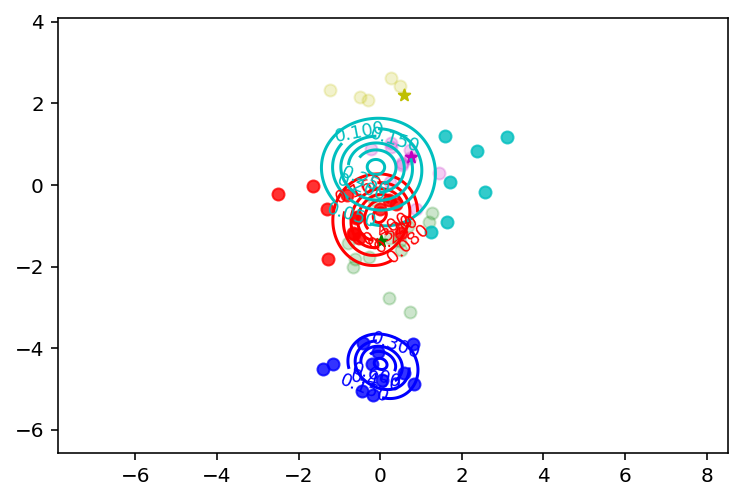

In [34]:
test_pretrain_visualize()

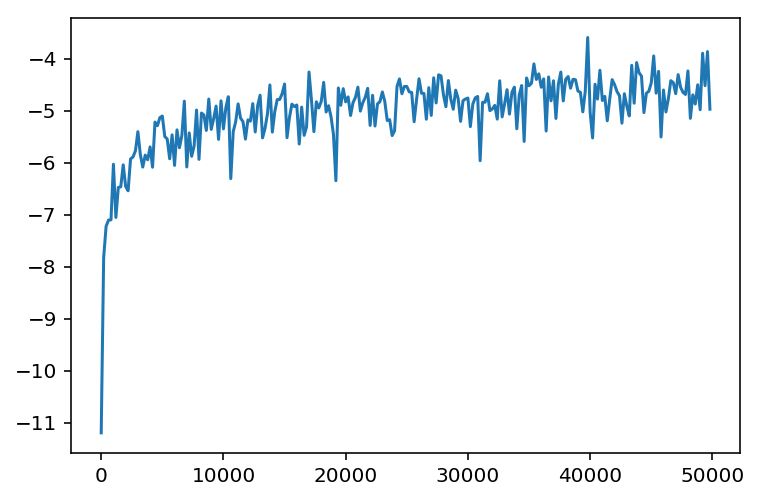

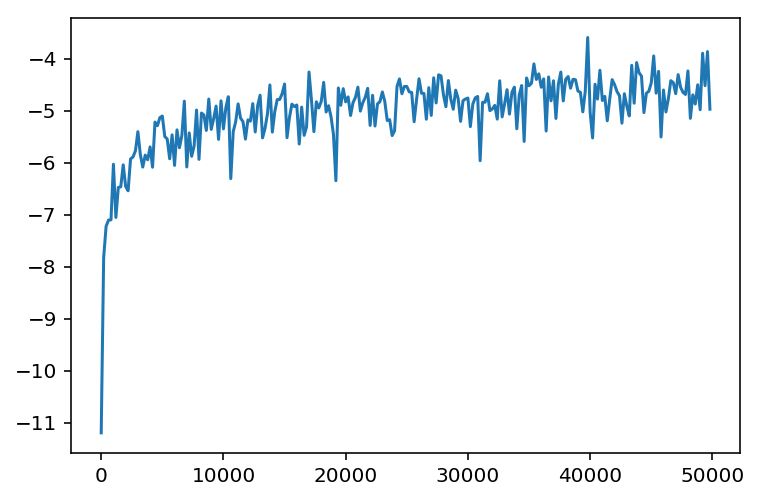

In [15]:
pretrain_prop_true(10, T = 50000, training_rate_fn = lambda t: 0.01, test_interval = 200)